In [1]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from scipy import stats

from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs, get_lonely_fields

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
COLORS = get_colors()

source = '/home/andrey/storage2/andrey/data/processed'
#source = '/storage2/andrey/data/processed'
paper = '/home/andrey/storage2/andrey/data/projects/24_shift/PAPER'
#paper = '/storage2/andrey/data/projects/24_shift/paper'
animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']

In [4]:
def get_idxs_by_quality(dataset):
    sic, pfr, iso = 0.2, 1.5, 15    # sic > 0.2, peak firing rate > 1.5 Hz, isolation distance > 15
    idxs_sic = (dataset['sic_A'] > sic) & (dataset['sic_B'] > sic)
    idxs_pfr = (dataset['peak_FR_A'] > pfr) & (dataset['peak_FR_B'] > pfr)
    idxs_iso = (dataset['isol_dist'] > iso)
    return idxs_sic & idxs_pfr & idxs_iso

In [6]:
def get_idxs_of_good_clu(ds):
    col_types = {'animal': str, 'session': str, 'electrode': int, 'unit': int}
    bad_clu = pd.read_csv(os.path.join(bad_clu_dir, 'all.csv'), dtype=col_types)
    
    all_idxs = np.array(ds.index.tolist())
    df = ds.copy()
    df['idxs'] = all_idxs
    
    bad_idxs = np.array(df.merge(bad_clu, on=['animal', 'session', 'electrode', 'unit'], how='inner')['idxs'])
    return np.isin(all_idxs, bad_idxs, invert=True)

In [7]:
def plot_hists(arrays, bins, titles, alpha):
    fig = plt.figure(figsize=(4*len(arrays), 4))
    
    for i, ds in enumerate(arrays):
        data = (-1) * ds
        ax = fig.add_subplot(1, len(arrays), i+1)
        ax.set_xlim(-0.4, 0.4)
        vals1 = ax.hist(data[data < 0], bins=bins, color=COLORS['a'], alpha=alpha[i][0], ec='black')
        vals2 = ax.hist(data[data > 0], bins=bins, color=COLORS['a'], alpha=alpha[i][1], ec='black')
        ax.axvline(0, color=COLORS['b'])
        ax.axvline(0.3, color=COLORS['b'])

        st, pv = stats.wilcoxon(data)
        hist_max = np.array([vals1[0].max(), vals2[0].max()]).max()

        ax.axvline(np.median(data), ls='--', color=COLORS['b'])
        ax.text(-0.35, 0.9 * hist_max, 'n = %d' % len(data), fontsize=14)
        ax.text(-0.35, 0.8 * hist_max, 'med = %.2f' % np.median(data), fontsize=14)
        ax.text(-0.35, 0.7 * hist_max, 'st=%.1f' % st, fontsize=14)
        ax.text(-0.35, 0.6 * hist_max, 'p=%.3f' % pv, fontsize=14)
        ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel('Field shift, m', fontsize=14)
        if i == 0:
            ax.set_ylabel('Number of fields', fontsize=14)
            
    return fig

### pSHIFT - no recalibration

In [13]:
s_list_single = get_sessions_list(source, animals, 'SHIFT single +dark')
s_list_periodic = get_sessions_list(source, animals, 'SHIFT periodic +dark')
s_comb = list(s_list_single) + (s_list_periodic)

single, periodic, combined = {}, {}, {}
for coll, lst in [[single, s_list_single], [periodic, s_list_periodic], [combined, s_comb]]:
    for cond_A, cond_B in [['A', 'B'], ['A', 'Ad'], ['B', 'Bd']]:
        coll[cond_A + cond_B] = get_fields_between_epochs(source, lst, cond_A, cond_B)

len(single['AB']), len(periodic['AB']), len(combined['AB'])

No required H5 file found for 2020-10-13_10-21-47
No required H5 file found for 2020-10-23_12-57-03
PF match found for 302 fields from total 573 A and 586 B fields
No required H5 file found for 2020-10-13_10-21-47
No required H5 file found for 2020-10-23_12-57-03
PF match found for 279 fields from total 569 A and 601 Ad fields
No required H5 file found for 2020-10-13_10-21-47
No required H5 file found for 2020-10-23_12-57-03
PF match found for 288 fields from total 573 B and 543 Bd fields
PF match found for 464 fields from total 925 A and 905 B fields
PF match found for 438 fields from total 922 A and 948 Ad fields
PF match found for 437 fields from total 896 B and 895 Bd fields
No required H5 file found for 2020-10-13_10-21-47
No required H5 file found for 2020-10-23_12-57-03
PF match found for 766 fields from total 1498 A and 1491 B fields
No required H5 file found for 2020-10-13_10-21-47
No required H5 file found for 2020-10-23_12-57-03
PF match found for 717 fields from total 1491 

(302, 464, 766)

In [34]:
# A-B-C-D field pairs
#df_AB  = combined['AB'][get_idxs_by_quality(combined['AB'])]
#df_AAd = combined['AAd'][get_idxs_by_quality(combined['AAd'])]
#df_BBd = combined['BBd'][get_idxs_by_quality(combined['BBd'])]

df_AB  = combined['AB']
df_AAd = combined['AAd']
df_BBd = combined['BBd']

df_AB   = df_AB.add_prefix('ab_')
df_AAd  = df_AAd.add_prefix('aad_')
df_BBd  = df_BBd.add_prefix('bbd_')

df_ABAd = df_AB.merge(df_AAd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
       right_on=['aad_animal', 'aad_session', 'aad_electrode', 'aad_unit', 'aad_field_A'], how='inner')
df_m = df_ABAd.merge(df_BBd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
       right_on=['bbd_animal', 'bbd_session', 'bbd_electrode', 'bbd_unit', 'bbd_field_A'], how='inner')

print(len(df_m))

485


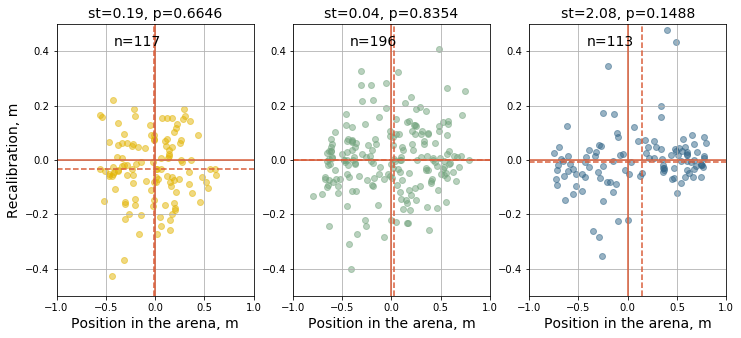

In [35]:
div = [-0.075, 0.075, 0.225, 0.375]
#div = [0., 0.1, 0.2, 0.3]
df_00 = df_m[(df_m['ab_shift'] > div[0]) & (df_m['ab_shift'] < div[1])]
df_15 = df_m[(df_m['ab_shift'] > div[1]) & (df_m['ab_shift'] < div[2])]
df_30 = df_m[(df_m['ab_shift'] > div[2]) & (df_m['ab_shift'] < div[3])]

fig = plt.figure(figsize=(12, 5))
colors = (COLORS['d'], COLORS['c'], COLORS['a'])

for i, ds in enumerate([df_00, df_15, df_30]):
    x_vals = (ds['ab_COMa_y'] + ds['ab_COMb_y']) / 2
    y_vals = (ds['ab_COMa_y'] + ds['ab_COMb_y']) / 2 - (ds['aad_COMb_y'] + ds['bbd_COMb_y']) / 2
    st, pv = stats.kruskal(x_vals, y_vals)

    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(x_vals, y_vals, color=colors[i], alpha=0.5)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-0.5, 0.5)
    ax.axvline(0, color=COLORS['b'])
    ax.axhline(0, color=COLORS['b'])
    ax.axvline(np.median(x_vals), ls='--', color=COLORS['b'])
    ax.axhline(np.median(y_vals), ls='--', color=COLORS['b'])
    #ax.set_aspect('equal')
    ax.set_title('st=%.2f, p=%.4f' % (st, pv), fontsize=14)
    ax.text(-0.42, 0.42, 'n=%d' % len(y_vals), fontsize=14)
    ax.set_xlabel('Position in the arena, m', fontsize=14)
    if i == 0:
        ax.set_ylabel('Recalibration, m', fontsize=14)
    ax.grid()

### GAIN

In [96]:
animals = ['003908', '003909', '005363', '005364']  # last four, add '003908', '003909'

sessions_12 = list(get_sessions_list(source, animals, 'GAIN 3 parts 1.2x'))
sessions_14 = list(get_sessions_list(source, animals, 'GAIN 3 parts 1.4x'))

data = {}
for cond_A, cond_B in [('A', 'B'), ('A', 'C'), ('C', 'D'), ('A', 'D')]:  # look for full / rate remapping in 14 A, C -> D
    for i, sessions in enumerate([sessions_12, sessions_14]):
        ds = get_fields_between_epochs(source, sessions, cond_A, cond_B)
        data['%s%s_%d' % (cond_A, cond_B, 12 + i*2)] = ds[get_idxs_by_quality(ds)]

PF match found for 574 fields from total 1080 A and 1030 B fields
PF match found for 341 fields from total 657 A and 623 B fields
PF match found for 523 fields from total 1080 A and 1010 C fields
PF match found for 314 fields from total 657 A and 624 C fields
PF match found for 543 fields from total 1006 C and 1018 D fields
PF match found for 320 fields from total 574 C and 548 D fields
PF match found for 491 fields from total 1078 A and 1018 D fields
PF match found for 261 fields from total 602 A and 548 D fields


In [97]:
df_AC_12 = data['AC_12'].add_prefix('ac_')
df_AD_12 = data['AD_12'].add_prefix('ad_')
df_CD_12 = data['CD_12'].add_prefix('cd_')
df_AC_14 = data['AC_14'].add_prefix('ac_')
df_AD_14 = data['AD_14'].add_prefix('ad_')
df_CD_14 = data['CD_14'].add_prefix('cd_')

df_ACD_12 = df_AC_12.merge(df_AD_12, left_on=['ac_animal', 'ac_session', 'ac_electrode', 'ac_unit', 'ac_field_A'], \
       right_on=['ad_animal', 'ad_session', 'ad_electrode', 'ad_unit', 'ad_field_A'], how='inner')
df_ACD_12 = df_ACD_12.merge(df_CD_12, left_on=['ac_animal', 'ac_session', 'ac_electrode', 'ac_unit', 'ac_field_B'], \
       right_on=['cd_animal', 'cd_session', 'cd_electrode', 'cd_unit', 'cd_field_A'], how='inner')

print(len(df_ACD_12))

221


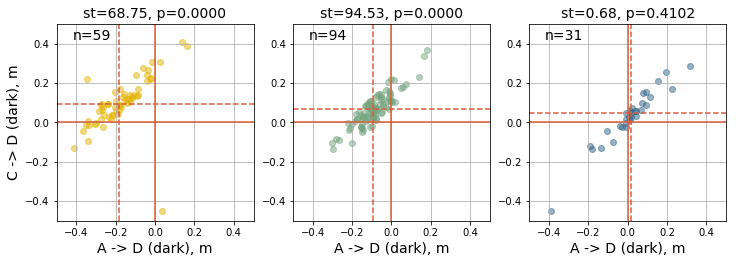

In [98]:
div = [-0.375, -0.225, -0.075, 0.075]

df_m = df_ACD_12.copy()
df_00 = df_m[(df_m['ac_shift'] > div[0]) & (df_m['ac_shift'] < div[1])]
df_15 = df_m[(df_m['ac_shift'] > div[1]) & (df_m['ac_shift'] < div[2])]
df_30 = df_m[(df_m['ac_shift'] > div[2]) & (df_m['ac_shift'] < div[3])]

fig = plt.figure(figsize=(12, 5))
colors = (COLORS['d'], COLORS['c'], COLORS['a'])

for i, ds in enumerate([df_00, df_15, df_30]):
    x_vals = ds['ad_shift']
    y_vals = ds['cd_shift']
    st, pv = stats.kruskal(x_vals, y_vals)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, y_vals)

    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(x_vals, y_vals, color=colors[i], alpha=0.5)
    #ax.plot(x_vals, intercept + slope*x_vals, color=colors[i])
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.axvline(0, color=COLORS['b'])
    ax.axhline(0, color=COLORS['b'])
    ax.axvline(np.median(x_vals), ls='--', color=COLORS['b'])
    ax.axhline(np.median(y_vals), ls='--', color=COLORS['b'])
    ax.set_aspect('equal')
    ax.set_title('st=%.2f, p=%.4f' % (st, pv), fontsize=14)
    ax.text(-0.42, 0.42, 'n=%d' % len(y_vals), fontsize=14)
    ax.set_xlabel('A -> D (dark), m', fontsize=14)
    if i == 0:
        ax.set_ylabel('C -> D (dark), m', fontsize=14)
    ax.grid()

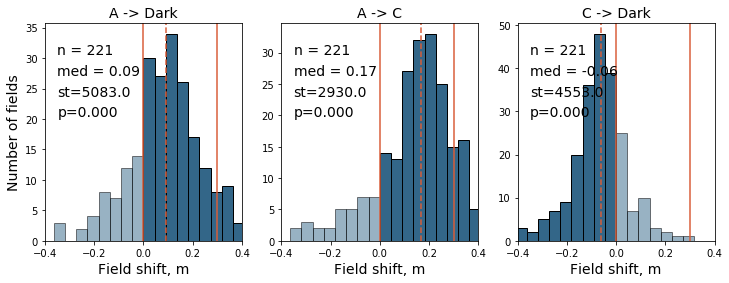

In [99]:
bins = np.linspace(-0.5, 0.5, 23)
titles = ['A -> Dark', 'A -> C', 'C -> Dark']
alpha = [(0.5, 1), (0.5, 1), (1, 0.5)]
arrays = [df_ACD_12['ad_shift'], df_ACD_12['ac_shift'], df_ACD_12['cd_shift']]

fig = plot_hists(arrays, bins, titles, alpha)

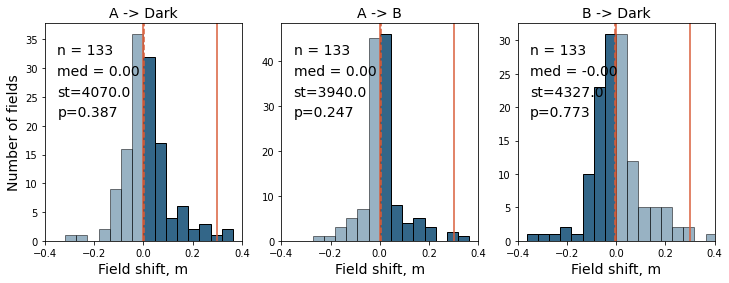

In [13]:
bins = np.linspace(-0.5, 0.5, 23)
titles = ['A -> Dark', 'A -> B', 'B -> Dark']
alpha = [(0.5, 1), (0.5, 1), (1, 0.5)]
#arrays = [df_ABDs['ad_shift'], df_ABDs['ab_shift'], df_ABDs['bd_shift']]
arrays = [df_ABDl['ad_shift'], df_ABDl['ab_shift'], df_ABDl['bd_shift']]

fig = plot_hists(arrays, bins, titles, alpha)

In [ ]:
gspec = gridspec.GridSpec(ncols=2, nrows=2)
fig = figure(figsize=(9, 8))
x_lim_l = -0.6
x_lim_r =  0.2
bins = np.arange(-0.6, 0.4, 0.03)

# A - B in light (should be 0.15), Ad - Bd in dark (should be 0.3)
data = np.array(shift_A_B_short[get_idxs_by_quality(shift_A_B_short)]['shift'])
ax = fig.add_subplot(gspec[0, 0])
ax.set_ylabel('Number of fields', fontsize=14)
ax.set_title("A -> B", fontsize=14)
plot_hist(ax, data, bins, x_lim_l, x_lim_r)
ax.text(ax.get_xlim()[0] - 0.15 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1], 'a', fontsize=16, fontweight='bold')


# B - D light/dark - should be 0.15 but actually ~0
bins = 30
data = np.array(shift_B_D_short[get_idxs_by_quality(shift_B_D_short)]['shift'])
ax = fig.add_subplot(gspec[0, 1])
ax.set_title("B -> dark", fontsize=14)
plot_hist(ax, data, bins, x_lim_l, x_lim_r)
ax.text(ax.get_xlim()[0] - 0.15 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1], 'b', fontsize=16, fontweight='bold')


# A - D light/dark (should be 0?) but actually < 0!
ax = fig.add_subplot(gspec[1, 0])
ax.set_ylabel('Number of fields', fontsize=14)
ax.set_title("A -> dark", fontsize=14)
plot_hist(ax, np.array(shift_A_D_short[get_idxs_by_quality(shift_A_D_short)]['shift']), 35, x_lim_l, x_lim_r)
ax.set_xlabel('Field shift in Arena ref.f., m', fontsize=14)
ax.text(ax.get_xlim()[0] - 0.15 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1], 'c', fontsize=16, fontweight='bold')


# scatter
# A-B-C field pairs
df_AB  = shift_A_B_short.add_prefix('ab_')
df_AD  = shift_A_D_short.add_prefix('ad_')
df_BD  = shift_B_D_short.add_prefix('bd_')

df1 = df_AB.merge(df_AD, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
        right_on=['ad_animal', 'ad_session', 'ad_electrode', 'ad_unit', 'ad_field_A'], how='inner')
df1 = df1.merge(df_BD, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
        right_on=['bd_animal', 'bd_session', 'bd_electrode', 'bd_unit', 'bd_field_A'], how='inner')

#df1 = shift_A_B_short.merge(shift_A_D_short, left_on=['animal', 'session', 'electrode', 'unit', 'field_A'], \
#        right_on=['animal', 'session', 'electrode', 'unit', 'field_A'], suffixes=('_l', '_d'), how='inner')
#df1 = df1.merge(shift_A_D_short, left_on=['animal', 'session', 'electrode', 'unit', 'field_A'], \
#        right_on=['animal', 'session', 'electrode', 'unit', 'field_A'], suffixes=('_l', '_d'), how='inner')

#df1 = df1[(df1['sic_A_l'] > 0.15) & (df1['sic_B_l'] > 0.15) & (df1['sic_B_d'] > 0.15)]
#df1 = df1[df1['isol_dist_l'] > 20]
#df1 = df1[(df1['peak_FR_A_l'] > 1.5) & (df1['peak_FR_B_l'] > 1.5) & (df1['peak_FR_B_d'] > 1.5)]
#match_both, match_A_D, match_B_D, match_none = get_matching_fields(shift_A_B_short, shift_B_D_short, shift_A_D_short)

shift_AB = (-1) * df1['ad_shift']
shift_AD = (-1) * df1['bd_shift']

ax = fig.add_subplot(gspec[1, 1])
#ax.set_xlim(x_lim_l, x_lim_r)
#ax.set_ylim(x_lim_l, x_lim_r)
ax.set_xlim(-0.4, 0.4)
ax.set_ylim(-0.4, 0.4)
ax.set_aspect('equal')
ax.grid()
ax.scatter(shift_AB, shift_AD, alpha=0.7, color=COLORS['a'])
#ax.scatter(shift_ABp, shift_ADp, alpha=0.7, color=COLORS['a'])
ax.axhline(0.0, color=COLORS['b'])
ax.axvline(0.0, color=COLORS['b'])
line = np.linspace(-1.0, 1.0, 10)
#ax.plot(line, line, color=COLORS['b'], label='no change line')
slope, intercept, r_value, p_value, std_err = stats.linregress(shift_AB, shift_AD)
st, pv = stats.kruskal(shift_AB, shift_AD)

#ax.plot(shift_AB, intercept + slope*shift_AB, ls='--', color=COLORS['a'])
#ax.plot([-0.6, 0.6], [-0.6, 0.6], ls='--', color=COLORS['b'])

ax.axvline(np.median(shift_AB), color=COLORS['b'], ls='--')
ax.axhline(np.median(shift_AD), color=COLORS['b'], ls='--')
ax.set_title('st=%.2f, p=%.3f' % (st, pv), fontsize=14)

ax.set_xlabel('Field shift A -> D (dark), m', fontsize=14)
ax.set_ylabel('Field shift A -> B (shifted), m', fontsize=14)
ax.text(ax.get_xlim()[0] - 0.15 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1], 'd', fontsize=16, fontweight='bold')


#fig.tight_layout()
#filename = "03-vSHIFT_shifts_in_diff_conditions_visual.png"
#fig.savefig(os.path.join(os.path.join(paper), filename))